In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('/Users/jordanlee/Projects/SummerProject/Bayesian')
import BOPackage

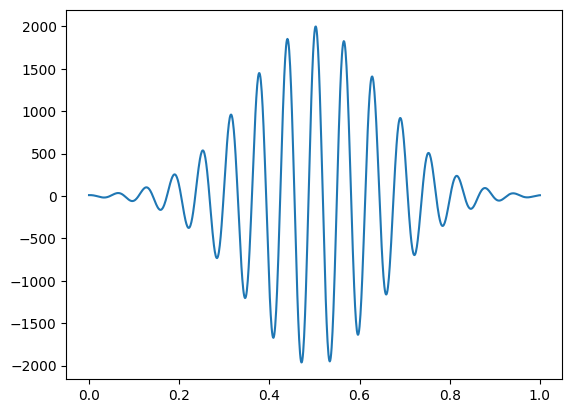

In [2]:
"""
Define the objective function.
"""

def ObjectiveFunction(x):
    x_centre = 0.5
    FWHM = 0.3
    width = FWHM / (2 * np.log(2))

    spatial_intensity =  np.exp(- ((x - x_centre) / width)**2)

    return 2000 * np.cos(100 * x) * spatial_intensity

X = np.linspace(0, 1, 1001, endpoint=True)

plt.plot(X, ObjectiveFunction(X))

In [3]:
"""
Configure the optimiser.
"""
Kernel = BOPackage.RBF_Kernel
length_scale = 0.1

AcquisitionFunction = BOPackage.UpperConfidenceBound
max_kappa = 10
min_kappa = 0.5

bounds = np.array([[0, 1]])
acquisition_samples = 100
random_seed = 27

# Create the object
bo = BOPackage.BO(KernelFunction=Kernel, 
                  length_scale=length_scale, 
                  AcquisitionFunction=AcquisitionFunction, 
                  bounds=bounds, 
                  acquisition_samples=acquisition_samples,
                  random_seed=random_seed)

In [4]:
"""
Get first random batch and update the optimiser.
"""

raw_X = bo.GetRandomXBatch(batch_size=4)
raw_y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_y)

bo.X_data, bo.y_data

(array([[0.42572141],
        [0.81458374],
        [0.73539729],
        [0.8680032 ]]),
 array([[ 284.34724326],
        [ 235.71406822],
        [-173.81482427],
        [  43.87156213]]))

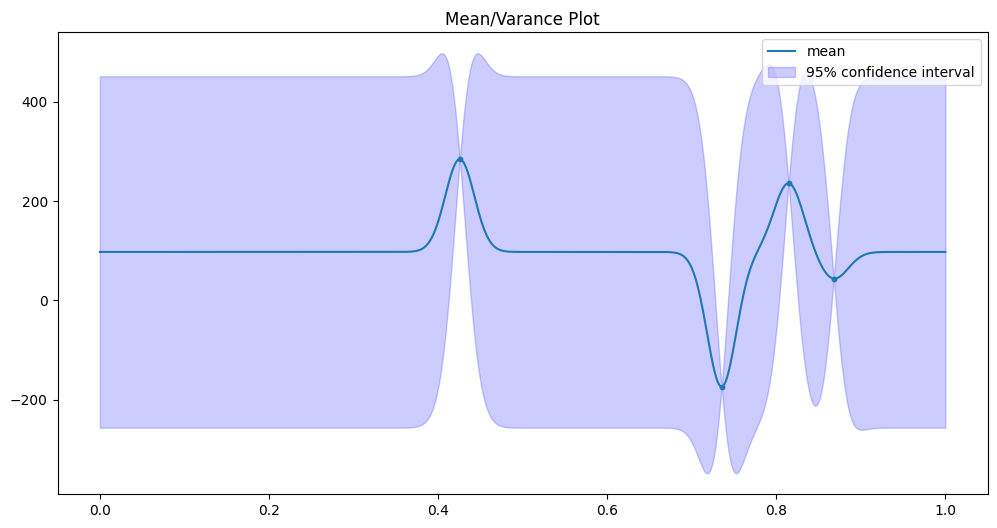

In [5]:
"""
Take a look at the mean and variance of the function now we have some data

NB: The y-axis is standardised such that the data is centered on the mean with a standard deviation of 1
"""

BOPackage.SausagePlot(bo)

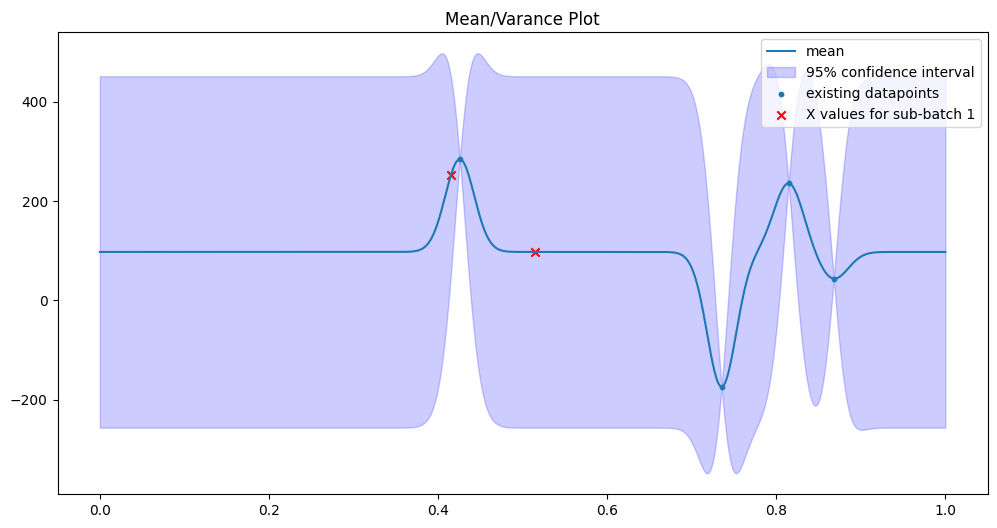

[[252.58086518]
 [ 97.52981411]]


In [6]:
"""
Next, we'll determine the upcoming batch of four X values, divided into sub-batches of two.
We'll start by selecting the first two X values for the initial sub-batch:

(Note: This is a demonstration of how the code operates; the method of execution will be shown below.)
"""

batch_size = 4
sub_batch_size = 2
raw_X = np.empty((batch_size,len(bo.bounds)))

sub_batch_X = np.empty((sub_batch_size, len(bo.bounds)))
sub_batch_y = np.empty((sub_batch_size, 1))

K_inv = bo.InverseKernel()

for i in range(sub_batch_size):

    kappa = bo.CalculateKappa(sub_batch_size, i, max_kappa, min_kappa)

    sub_batch_X[i] = bo.GetNextX(kappa, K_inv=K_inv)

    raw_X[i] = sub_batch_X[i]

sub_batch_y = bo.PredictMeanVariance(np.array(sub_batch_X), K_inv=K_inv)[0]

plt.figure(figsize=(12, 6))

sample_points = np.linspace(0, 1, 1000, endpoint=True).reshape(1000,1)

mean, variance = bo.PredictMeanVariance(sample_points)

plt.plot(sample_points, mean, label='mean')
plt.fill_between(sample_points[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')

plt.scatter(bo.X_data, bo.y_data, s=10, label='existing datapoints')

plt.scatter(sub_batch_X, sub_batch_y, color='red', marker='x', label='X values for sub-batch 1')

plt.title("Mean/Varance Plot")

plt.legend()

# Display the plot
plt.show()

print(sub_batch_y)

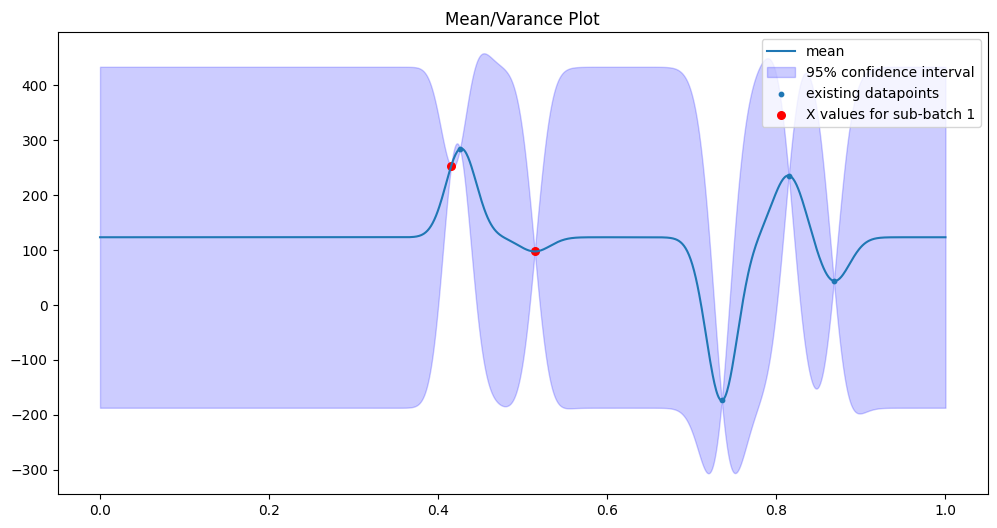

In [7]:
"""
Rather than calculating the actual y value for our new X values at this stage, we temporarily assign them the mean y value at these point.

Next, we recalculate the mean and variance with these new X values. Notice that the confidence interval drops to 0 at the new X values, even though the corresponding y values have not yet been calculated.
"""

bo.X_data = np.vstack([bo.X_data, sub_batch_X])

if bo.minimize is True:
    sub_batch_y = -sub_batch_y

bo.y_data = np.vstack([bo.y_data, sub_batch_y])

plt.figure(figsize=(12, 6))

sample_points = np.linspace(0, 1, 1000, endpoint=True).reshape(1000,1)

mean, variance = bo.PredictMeanVariance(sample_points)

plt.plot(sample_points, mean, label='mean')
plt.fill_between(sample_points[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')

plt.scatter(bo.X_data, bo.y_data, s=10, label='existing datapoints')

plt.scatter(bo.X_data[-sub_batch_size:], bo.y_data[-sub_batch_size:], s=30, color='red', label='X values for sub-batch 1')

plt.title("Mean/Varance Plot")

plt.legend()

# Display the plot
plt.show()


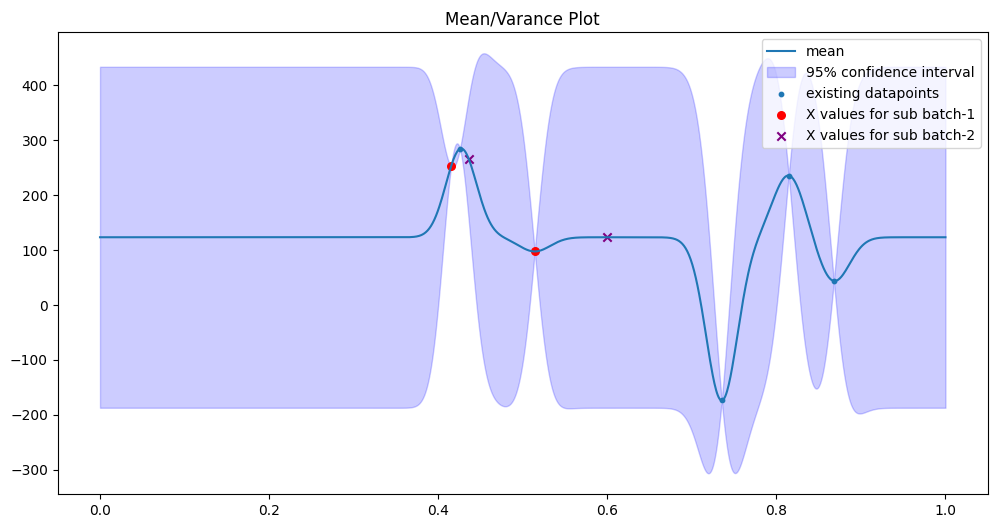

[[265.84640819]
 [123.3708902 ]]


In [8]:
"""
Next, we repeat this process for sub batch two:
"""

sub_batch_X = np.empty((sub_batch_size, len(bo.bounds)))
sub_batch_y = np.empty((sub_batch_size, 1))

K_inv = bo.InverseKernel()

for i in range(sub_batch_size):

    kappa = bo.CalculateKappa(sub_batch_size, i, max_kappa, min_kappa)

    sub_batch_X[i] = bo.GetNextX(kappa, K_inv=K_inv)

    sub_batch_y[i] = bo.PredictMeanVariance(np.array([sub_batch_X[i]]), K_inv=K_inv)[0]

    raw_X[i + sub_batch_size] = sub_batch_X[i]

plt.figure(figsize=(12, 6))

sample_points = np.linspace(0, 1, 1000, endpoint=True).reshape(1000,1)

mean, variance = bo.PredictMeanVariance(sample_points)

plt.plot(sample_points, mean, label='mean')
plt.fill_between(sample_points[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')

plt.scatter(bo.X_data, bo.y_data, s=10, label='existing datapoints')

plt.scatter(bo.X_data[-sub_batch_size:], bo.y_data[-sub_batch_size:], s=30, color='red', label='X values for sub batch-1')

plt.scatter(sub_batch_X, sub_batch_y, color='purple', marker='x', label='X values for sub batch-2')

plt.title("Mean/Varance Plot")

plt.legend()

# Display the plot
plt.show()

print(sub_batch_y)


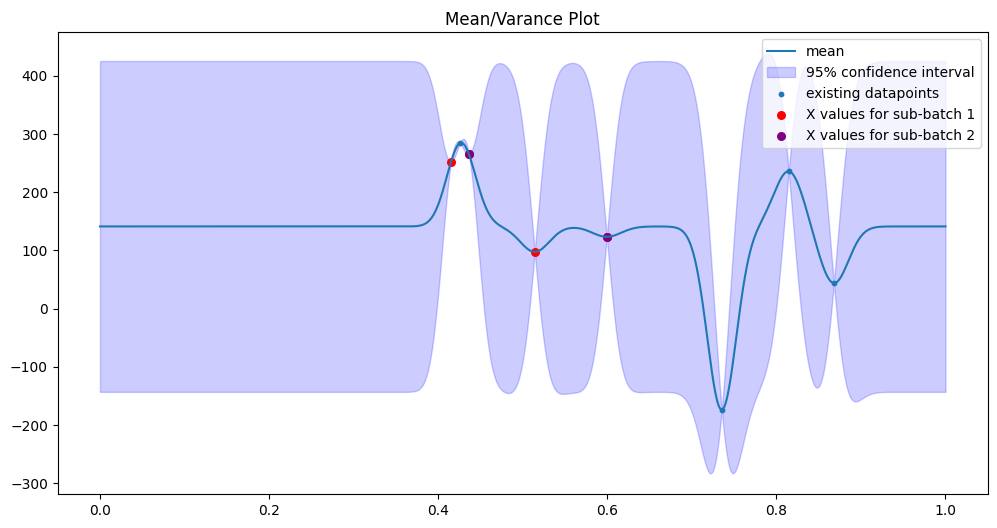

In [9]:
"""
Again, we recalculate the mean and variance for these new points and their corresponding means:
"""

bo.X_data = np.vstack([bo.X_data, sub_batch_X])

bo.y_data = np.vstack([bo.y_data, sub_batch_y])

plt.figure(figsize=(12, 6))

sample_points = np.linspace(0, 1, 1000, endpoint=True).reshape(1000,1)

mean, variance = bo.PredictMeanVariance(sample_points)

plt.plot(sample_points, mean, label='mean')
plt.fill_between(sample_points[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')

plt.scatter(bo.X_data, bo.y_data, s=10, label='existing datapoints')

plt.scatter(bo.X_data[-sub_batch_size*2:], bo.y_data[-sub_batch_size*2:], s=30, color='red', label='X values for sub-batch 1')

plt.scatter(bo.X_data[-sub_batch_size:], bo.y_data[-sub_batch_size:], s=30, color='purple', label='X values for sub-batch 2')


plt.title("Mean/Varance Plot")

plt.legend()

# Display the plot
plt.show()


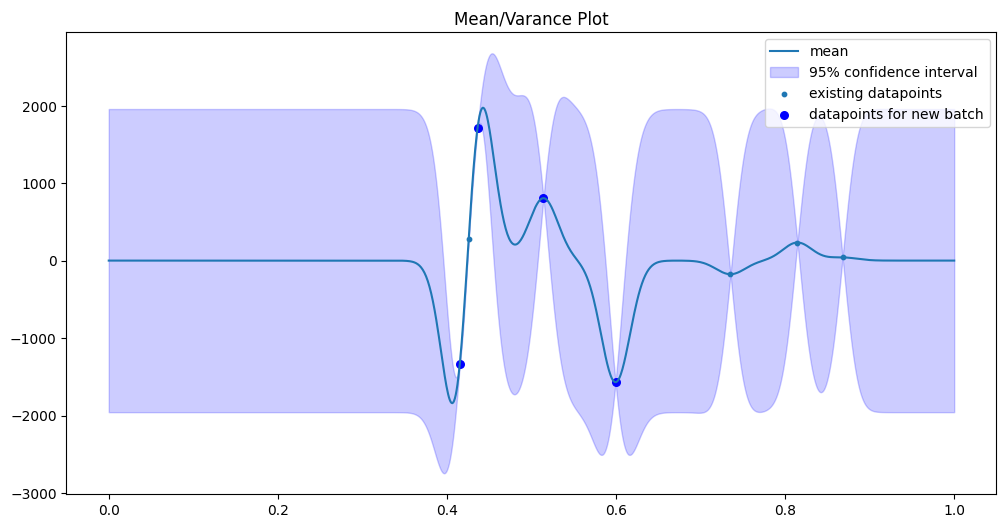

In [10]:
"""
These four points are now are X values for this batch. We pass these X values through our function to find the corresponding y values and find our new mean and variance.
"""

bo.X_data = bo.X_data[:-batch_size]
bo.y_data = bo.y_data[:-batch_size]

raw_y = ObjectiveFunction(raw_X)

bo.UpdateData(raw_X, raw_y)

plt.figure(figsize=(12, 6))

sample_points = np.linspace(0, 1, 1000, endpoint=True).reshape(1000,1)

mean, variance = bo.PredictMeanVariance(sample_points)

plt.plot(sample_points, mean, label='mean')
plt.fill_between(sample_points[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')

plt.scatter(bo.X_data, bo.y_data, s=10, label='existing datapoints')

plt.scatter(bo.X_data[-sub_batch_size*2:], bo.y_data[-sub_batch_size*2:], s=30, color='blue', label='datapoints for new batch')

plt.title("Mean/Varance Plot")

plt.legend()

# Display the plot
plt.show()


# Doing this with the package:

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('/Users/jordanlee/Projects/SummerProject/Bayesian')
import BOPackage

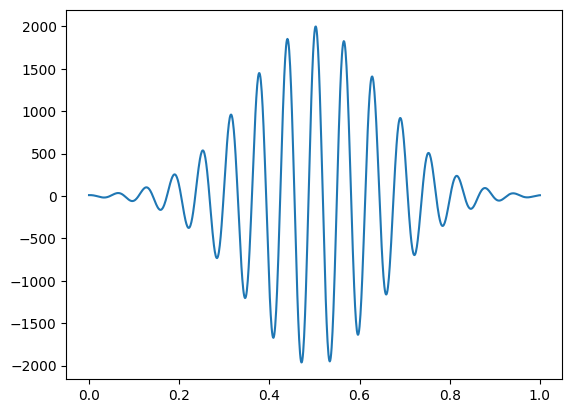

In [12]:
"""
Define the objective function.
"""

def ObjectiveFunction(x):
    x_centre = 0.5
    FWHM = 0.3
    width = FWHM / (2 * np.log(2))

    spatial_intensity =  np.exp(- ((x - x_centre) / width)**2)

    return 2000 * np.cos(100 * x) * spatial_intensity

X = np.linspace(0, 1, 1001, endpoint=True)

plt.plot(X, ObjectiveFunction(X))

In [13]:
"""
Configure the optimiser.
"""
Kernel = BOPackage.RBF_Kernel
length_scale = 0.1

AcquisitionFunction = BOPackage.UpperConfidenceBound
max_kappa = 10
min_kappa = 0.5

bounds = np.array([[0, 1]])
acquisition_samples = 100
random_seed = 27

batch_size = 4
sub_batch_size = 2

# Create the object
bo = BOPackage.BO(KernelFunction=Kernel, 
                  length_scale=length_scale, 
                  AcquisitionFunction=AcquisitionFunction, 
                  bounds=bounds, 
                  acquisition_samples=acquisition_samples,
                  random_seed=random_seed)

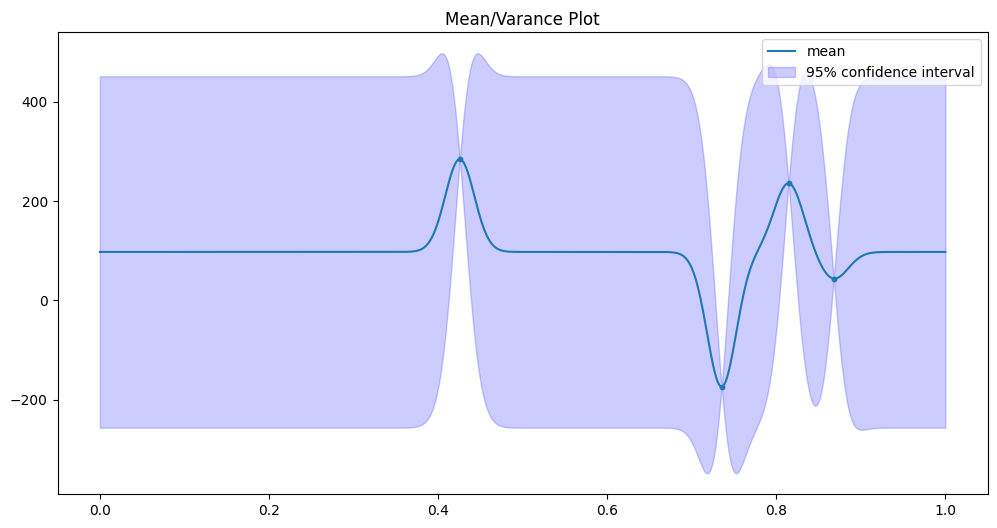

In [14]:
"""
Get first random batch and update the optimiser.
"""

raw_X = bo.GetRandomXBatch(batch_size=4)
raw_y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_y)

BOPackage.SausagePlot(bo)

/Users/jordanlee/Projects/SummerProject/Bayesian/BOPackage.py:1004: RuntimeWarning: invalid value encountered in subtract
  diff = X1_scaled[:, np.newaxis, :] - X2_scaled[np.newaxis, :, :]  # Shape (n_X, n_Y, d)


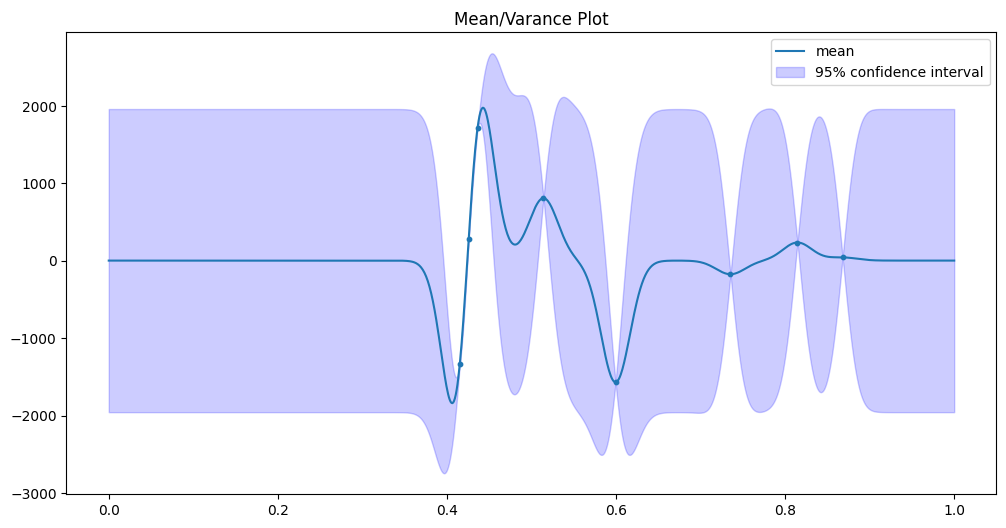

In [15]:
raw_X = bo.GetNextXBatch(batch_size, sub_batch_size, max_kappa=max_kappa, min_kappa=min_kappa)
raw_y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_y)

BOPackage.SausagePlot(bo)